In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader
from torchvision import transforms, datasets
from tqdm.notebook import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Forming a dataset

In [3]:
DATASET_PATH = "lfw-deepfunneled"
ATTRIBUTE_PATH = "lfw_attributes.txt"

In [4]:
# Images shape is 250x250
image_transforms = transforms.Compose([
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.4193, 0.3641, 0.3246],
    #                    std=[0.2773, 0.2498, 0.2384])
])

full_dataset = datasets.ImageFolder(root=DATASET_PATH, transform=image_transforms)
#  check that all images are in the dataset
assert len(full_dataset.samples) == 13233

batch_size = 32

# full_dataloader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)

In [5]:
# num of unique persons
len(full_dataset.classes)

5749

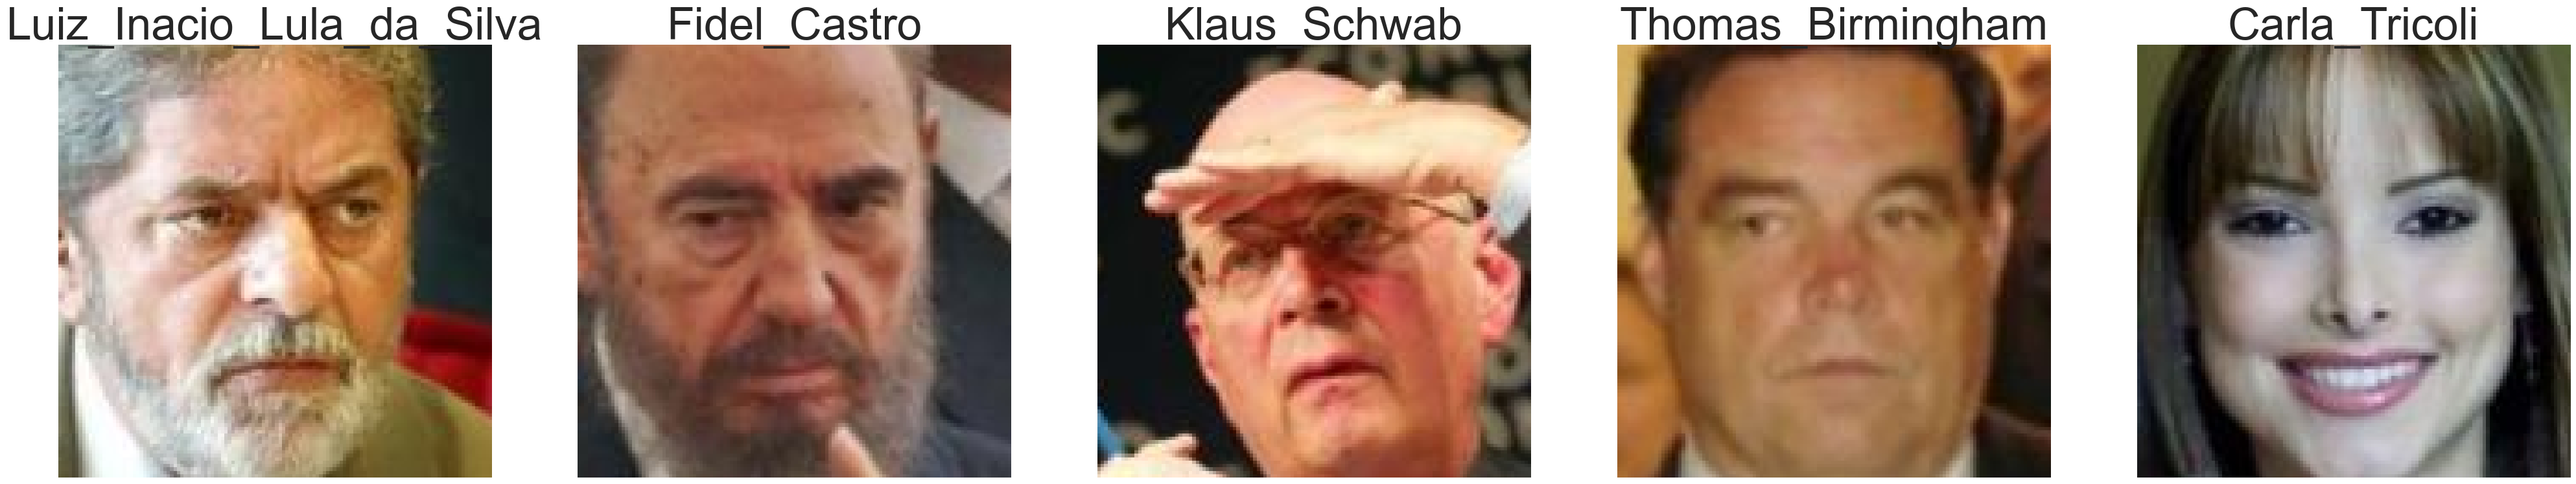

In [6]:
def show_random_images(dataset, num=5):
    plt.figure(figsize=(num * 10, 10))
    indices = np.random.choice(len(dataset), num)
    for i, id in enumerate(indices):
        x, y = dataset[id]
        plt.subplot(1, num, i + 1)
        plt.title(dataset.classes[y], fontsize=50)
        plt.imshow(x.permute(1, 2, 0))
        plt.grid(False)
        plt.axis("off")

show_random_images(full_dataset, 5)

In [7]:
# let's find mean and std for dataset
# def get_mean_std(loader):
#     mean = 0.0
#     std = 0.0
#     total_images_count = 0
#     for images, _ in loader:
#         batch_samples = images.size(0)
#         images = images.view(batch_samples, images.size(1), -1)
#         mean += images.mean(2).sum(0)
#         std += images.std(2).sum(0)
#         total_images_count += batch_samples
#
#     mean /= total_images_count
#     std /= total_images_count
#     return mean, std

# Вычисляем средние и стандартные отклонения
# mean, std = get_mean_std(dataloader)

In [7]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [8]:
in_channels = 3
out_channels = 32
kernel_size = 3
latent_dim = 512

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            # size: 128x128, channels: 3
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # size: 64x64, channels: 32
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels * 2, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(num_features=out_channels * 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # size: 32x32, channels: 64
            nn.Conv2d(in_channels=out_channels * 2, out_channels=out_channels * 4, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(num_features=out_channels * 4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # size: 16x16, channels: 128
            nn.Flatten(),
            nn.Linear(16 * 16 * out_channels * 4, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16 * 16 * out_channels * 4),
            nn.Unflatten(1, (out_channels * 4, 16, 16)),
            nn.ConvTranspose2d(in_channels=out_channels * 4, out_channels=out_channels * 2, kernel_size=kernel_size, padding=1, stride=2, output_padding=1),
            nn.BatchNorm2d(num_features=out_channels * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=out_channels * 2, out_channels=out_channels, kernel_size=kernel_size, padding=1, stride=2, output_padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=in_channels, kernel_size=kernel_size, padding=1, stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return  encoded, decoded

    def sample(self, X_encoded):
        decoded = self.decoder(X_encoded)
        return decoded

In [34]:
summary(Autoencoder().to(device), (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                  [

In [26]:
def train_loop(model, loader, loss, optimizer):
    loss_accum = 0.0
    total_samples = 0
    model.train()
    for (X, _) in loader:
        X_gpu = X.to(device)
        encoder, decoder = model(X_gpu)
        loss_val = loss(decoder, X_gpu)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        total_samples += X_gpu.shape[0]
        loss_accum += loss_val.item() * X_gpu.shape[0]

    train_loss = loss_accum / total_samples
    return train_loss

def val_loop(model, loader, loss):
    loss_accum = 0.0
    total_samples = 0
    model.eval()

    with torch.no_grad():
        for (X, _) in loader:
            X_gpu = X.to(device)
            encoder, decoder = model(X_gpu)
            loss_val = loss(decoder, X_gpu)

            total_samples += X_gpu.shape[0]
            loss_accum += loss_val.item() * X_gpu.shape[0]

        val_loss = loss_accum / total_samples

    # show one image during training
    im_id = 15
    with torch.no_grad():
        img, label = val_loader.dataset[im_id]
        img_to_model = torch.FloatTensor(img.unsqueeze(0)).to(device)
        encoder, decoder = autoencoder(img_to_model)
        decoded_img = decoder.squeeze(0)

        img = img.to("cpu")
        decoded_img = decoded_img.to("cpu")

        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"Original Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(decoded_img.permute(1, 2, 0))
        plt.title("Decoded Image")
        plt.axis('off')

        plt.show()
    return val_loss


def train(model, train_loader, val_loader, epochs, save_weights=False, scheduler=False):
    loss = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-5, momentum=0.9)
    if scheduler:
        # scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.2, patience=5, min_lr=1e-7)
        scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)
    loss_history = []

    with tqdm(desc="epoch", total=epochs) as pbar:
        for epoch in range(epochs):
            train_loss = train_loop(model, train_loader, loss, optimizer)
            val_loss = val_loop(model, val_loader, loss)
            loss_history.append((train_loss, val_loss))
            pbar.write(f"Epoch: {epoch + 1} train_loss: {train_loss:.4f} val_loss: {val_loss:.4f}")
            pbar.update(1)
            if save_weights:
                torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pt')
    return loss_history

In [27]:
autoencoder = Autoencoder()
autoencoder.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=32768, out_features=512, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=51

In [28]:
autoencoder.load_state_dict(torch.load("0.0023 val loss.pt"))

C:\Users\MSI\AppData\Local\Temp\ipykernel_16712\3902776346.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load("0.0023 val loss.pt"))


<All keys matched successfully>

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

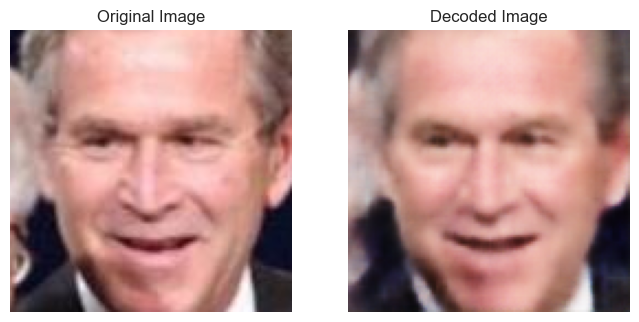

Epoch: 1 train_loss: 0.0017 val_loss: 0.0015


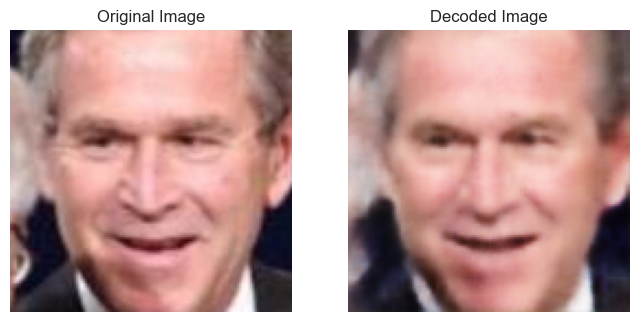

Epoch: 2 train_loss: 0.0017 val_loss: 0.0015


In [29]:
history = train(autoencoder, train_loader, val_loader, 2, save_weights=False, scheduler=True)

In [31]:
# save params and load them
autoencoder.load_state_dict(torch.load("final_params.pt"))

C:\Users\MSI\AppData\Local\Temp\ipykernel_16712\3470046225.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load("final_params.pt"))


<All keys matched successfully>

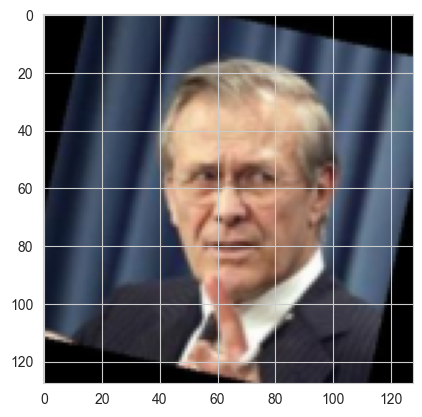

In [50]:
x, _ = val_loader.dataset[3]
plt.imshow(x.permute(1, 2, 0))

In [44]:
def plot_loss_history(loss_history):
    train_losses = [x[0] for x in loss_history]
    val_losses = [x[1] for x in loss_history]

    epochs = range(1, len(loss_history) + 1)

    plt.figure(figsize=(28, 6))
    plt.plot(epochs, train_losses, label='Train Loss', )
    plt.plot(epochs, val_losses, label='Validation Loss')

    plt.title('Training and Validation Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [45]:
plot_loss_history(history)

NameError: name 'history' is not defined

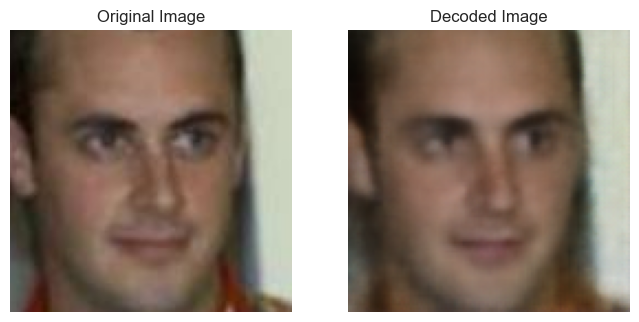

In [33]:
im_id = 8
with torch.no_grad():
    img, label = val_loader.dataset[im_id]
    img_to_model = torch.FloatTensor(img.unsqueeze(0)).to(device)
    encoder, decoder = autoencoder(img_to_model)
    decoded_img = decoder.squeeze(0)

    img = img.to("cpu")
    decoded_img = decoded_img.to("cpu")

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(decoded_img.permute(1, 2, 0))
    plt.title("Decoded Image")
    plt.axis('off')